<a href="https://colab.research.google.com/github/Kristin33/Composer-Clustering/blob/master/feature_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:


import os, sys
import librosa, librosa.display
import matplotlib.pyplot as plt 

from scipy import stats

import numpy as np 
import pandas as pd 

from PIL import Image
from time import time

from sklearn.cluster import SpectralClustering, MeanShift, KMeans, AgglomerativeClustering


# Data directories and experiment

In [0]:
# directory variables 

# 之前我试csv的时候
alkan_csv = "alkan_all.csv"
bach_csv = "bach_all.csv"
beethoven_csv = "beethoven_all.csv"
brahms_csv = "brahms_all.csv"
buxtehude_csv = "buxtehude_all.csv"
byrd_csv = "byrd_all.csv"
chopin_csv = "chopin_all.csv"
dandrieu_csv = "dandrieu_all.csv"
dvorak_csv = "dvorak_all.csv"
debussy_csv = "debussy_all.csv"
faure_csv = "faure_all.csv"
handel_csv = "handel_all.csv"
haydn_csv = "haydn_all.csv"
mozart_csv = "mozart_all.csv"
scarlatti_csv = "scarlatti_all.csv"
schubert_csv = "schubert_all.csv"
schumann_csv = "schumann_all.csv"
scriabin_csv = "scriabin_all.csv"
shostakovich_csv = "shostakovich_all.csv"
soler_csv = "soler_all.csv"

train_csv_comps = [alkan_csv, bach_csv,
                   brahms_csv, buxtehude_csv, byrd_csv, 
                   chopin_csv, dandrieu_csv, dvorak_csv, debussy_csv,
                   faure_csv, handel_csv, haydn_csv,
                   mozart_csv, scarlatti_csv, schubert_csv,
                  schumann_csv, scriabin_csv, shostakovich_csv, soler_csv]
test_csv_comps = [alkan_csv, bach_csv, beethoven_csv,
                   brahms_csv]
                  # , buxtehude_csv, byrd_csv, 
                  #  chopin_csv, dandrieu_csv, dvorak_csv,
                  #  faure_csv, handel_csv, haydn_csv,
                  #  mozart_csv, scarlatti_csv, schubert_csv,
                  # schumann_csv, scriabin_csv, shostakovich_csv, soler_csv]


In [0]:


"""
===========================================================
Get the piano roll encoding of midi files 
===========================================================

Attempt of using autoencoders to encode the pianoroll representation
into a lower dimension latent representation. 

currently, the input of the piano roll is of dimension 128000

"""

# dimension: 128 * 1000
# 128: midi 有128个note，C4 = 60
# 1000，对于时间上的sampling
# matrix 里面，应该是0-127之间的一个数，表示这个音的音量
def get_piano_roll_matrix(midi_data, start_pitch, end_pitch, fs=50, draw=False):
    # roll = midi_data.get_piano_roll(fs)[start_pitch:end_pitch]
    matrix = midi_data.get_piano_roll(fs)[:, :1000]
    # print(matrix[:, 30:40])
    # print(matrix.shape)

    if draw: 
      print("drawing...")
      librosa.display.specshow(matrix,
            hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
            fmin=pretty_midi.note_number_to_hz(start_pitch))
    return np.array(matrix)

# input: an array of test composers, like [scirabin_dir, bach_dir]
def extract_rolls(comps, verbose=False):
    
    data_dir = "New_Data_Selection/"

    for idx, comp in enumerate(comps):
      print(comp)
      for filename in os.listdir(data_dir + comp):
          
          if ".mid" in filename or ".MID" in filename:
              if verbose:
                print(filename)
              try:
                midi_data = pretty_midi.PrettyMIDI(data_dir + comp + filename)
                l = midi_data.get_end_time()
                # scale the sampling frequency by the length of data, so the picture is 
                # of the same size 128 * 1000
                fs = 50 * (1000/(l * 50 - 1))
                roll = get_piano_roll_matrix(midi_data,36,108,fs=fs,draw=False)

                # plt.gray()
                if not os.path.exists('pianoroll/{}'.format(comp)):
                  os.mkdir('pianoroll/{}'.format(comp))
                plt.imsave("pianoroll/{}/{}.png".format(comp, filename),
                          roll)
                print(filename + "saved")
                # print(np.sum(roll, axis=0))
              except Exception as e: 
                print(e)
                pass

    return 

# read all the file in the composer directory, and return 
# np array of (n, 128, 1000)
def read_comp(comp):
  path = "pianoroll/" + comp
  data = np.empty((0, 128, 1000))
  for filename in os.listdir(path):
    img = np.asarray(Image.open("{}/{}".format(path, filename)).convert("L"))
    np.append(data, img, axis=0)
    print(img.shape)
  return data


def get_train_data(train_comps):
    
    data_dir = "drive/My Drive/10701/pianoroll/"

    composer_data = np.empty((0, 776))
    composer_label = np.empty((0,))


    for comp in train_comps:
        data = read_comp(comp)

        composer_data = np.append(composer_data, data, axis=0)
        composer_label = np.append(composer_label, np.zeros((data.shape[0],)), axis=0)

    data = composer_data
    labels = composer_label

    return data, labels


# Fetch data: old csv files

In [0]:
def get_csv_train_data(train_csv_comps):
    
    data_dir = "drive/My Drive/10701/composer_csv/"

    composer_data = np.empty((0, 776))
    composer_label = np.empty((0,))

    for filename in train_csv_comps:
        data = np.genfromtxt(data_dir + filename, delimiter=',', 
                             usecols=np.arange(1,777), encoding="latin1")
        # get rid of the top row with feature names
        data = data[1:,:]

        composer_data = np.append(composer_data, data, axis=0)
        composer_label = np.append(composer_label, np.zeros((data.shape[0],)), axis=0)

    data = composer_data
    # standarize the data
    data = stats.zscore(data)
    data = np.nan_to_num(data)
    labels = composer_label

    return data, labels

def get_csv_test_data(test_csv_comps):
    
    data_dir = "drive/My Drive/10701/composer_csv/"

    composer_data = np.empty((0, 776))
    composer_label = np.empty((0,))
    

    for idx, filename in enumerate(test_csv_comps):
        print(filename)
        data = np.genfromtxt(data_dir + filename, delimiter=',', 
                             usecols=np.arange(1,777), encoding='latin1')
        # get rid of the top row with feature names
        data = data[1:,:]
        # standarize the data
        data = stats.zscore(data)
        data = np.nan_to_num(data)

        composer_data = np.append(composer_data, data, axis=0)
        composer_label = np.append(composer_label, np.ones((data.shape[0],)) * idx, axis=0)

    data = composer_data
    labels = composer_label

    return data, labels


# d, l = get_csv_train_data([dandrieu_csv])


# Fetch training data for autoencoders

In [0]:
"""
===========================================================
Auto encoders
===========================================================

Attempt of using autoencoders to encode the pianoroll representation
into a lower dimension latent representation. 

currently, the input of the piano roll is of dimension 1280000


"""

import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%tensorflow_version 1.x
import tensorflow as tf
# from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from keras import regularizers




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
(x_train, y_train) = get_csv_train_data(train_csv_comps)

# x_train = x_train.astype('float32') / 255.0

# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))


print(x_train.shape)

(4202, 776)


# Construct Model and Train

In [0]:
# 返回一个autoencoder的model
def get_ae(input_size):
  # if using piano roll, input_size = 1280000, if jSymbolic feature, size is 776 
  hidden_size = 128
  code_size = 32

  input_img = Input(shape=(input_size,))
  hidden_1 = Dense(hidden_size, activation='relu')(input_img)
  code = Dense(code_size, activation='relu')(hidden_1)
  hidden_2 = Dense(hidden_size, activation='relu')(code)
  output_img = Dense(input_size, activation='sigmoid')(hidden_2)


  # input_img = Input(shape=(input_size,))
  # encoded = Dense(128, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
  # encoded = Dense(64, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
  # encoded = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
  # code = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
  # decoded = Dense(32, activation='relu')(code)
  # decoded = Dense(64, activation='relu')(decoded)
  # decoded = Dense(128, activation='relu')(decoded)
  # output_img = Dense(input_size, activation='sigmoid')(decoded)


  autoencoder = Model(input_img, output_img)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder_half = Model(input_img, code)

  return autoencoder, autoencoder_half



In [0]:
# train autoencoder 


# if using piano roll, input_size = 1280000, if jSymbolic feature, size is 776 
input_size = 776
# autoencoder, autoencoder_half = get_ae(input_size)
# autoencoder_train = autoencoder.fit(x_train, x_train, epochs=10)


# # 可以改（成get_ae）！但是记得要把x_train改成正确的dimension，而且x_test也要同时改了
# autoencoder = get_conv_ae(input_size)
# # x_train = np.reshape(x_train, (len(x_train), 1, 128, 10000))
# a = np.reshape(x_train, (len(x_train), 128, 10000, 1))
# x_train_new = a[:, 8:, 8:, :]
# autoencoder_train = autoencoder.fit(x_train_new, x_train_new,
#                 nb_epoch=2)

# 可以改（成get_ae）！但是记得要把x_train改成正确的dimension，而且x_test也要同时改了
autoencoder, autoencoder_half = get_ae(input_size)
autoencoder_train = autoencoder.fit(x_train, x_train,
                nb_epoch=100)




Train on 4202 samples
Epoch 1/100
4202/4202 [==============================] - 1s 137us/sample - loss: -179.2717
Epoch 2/100
4202/4202 [==============================] - 0s 99us/sample - loss: -20192.8553
Epoch 3/100
4202/4202 [==============================] - 0s 97us/sample - loss: -202539.6641
Epoch 4/100
4202/4202 [==============================] - 0s 96us/sample - loss: -878092.7843
Epoch 5/100
4202/4202 [==============================] - 0s 97us/sample - loss: -2558833.5420
Epoch 6/100
4202/4202 [==============================] - 0s 100us/sample - loss: -5856639.0281
Epoch 7/100
4202/4202 [==============================] - 0s 100us/sample - loss: -11444564.0485
Epoch 8/100
4202/4202 [==============================] - 0s 99us/sample - loss: -20013059.0062
Epoch 9/100
4202/4202 [==============================] - 0s 97us/sample - loss: -32406598.9567
Epoch 10/100
4202/4202 [==============================] - 0s 99us/sample - loss: -49305878.6140
Epoch 11/100
4202/4202 [==============

# Fetch testing data and cluster

In [0]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import v_measure_score, adjusted_rand_score

vms = v_measure_score
nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [0]:


def run_representation_clustering(files, save=False):

  test_comps = files

  (x_test, y_test) = get_csv_test_data(test_comps)
  # if using piano roll, x_test.shape should be n * 1280000, n is the number of 
  # test samples. If using csv, x_test.shape should be n * 776
  print(x_test.shape)
  # x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

  # using autoencoders
  x_test_rep = autoencoder_half.predict(x_test)

  n = len(np.unique(files))

  print(x_test_rep.shape)
  kmeans = KMeans(n_clusters=n, random_state=0).fit(x_test_rep)
  labels = kmeans.labels_
  y_pred = labels

  if save:
    name = "_".join([f[:4] for f in files]) 
    drive_dir = "drive/My Drive/10701/"
    with open(drive_dir + "results/represented_feature/f1/{}.txt".format(name), "w") as f:
      f.write(", ".join([f[:-4] for f in files]) + "\n")
      f.write("acc: {}\n".format(acc(y_test, y_pred)))
      f.write("vms: {}\n".format(vms(y_test, y_pred)))
      f.write("nmi: {}\n".format(nmi(y_test, y_pred)))
      f.write("ari: {}\n".format(ari(y_test, y_pred)))
   
  return acc(y_test, y_pred)

alkan_all.csv
alkan_all.csv
(410, 776)
(410, 32)
alkan_all.csv
bach_all.csv
(1200, 776)
(1200, 32)
alkan_all.csv
beethoven_all.csv
(689, 776)
(689, 32)
alkan_all.csv
brahms_all.csv
(324, 776)
(324, 32)
alkan_all.csv
buxtehude_all.csv
(277, 776)
(277, 32)
alkan_all.csv
byrd_all.csv
(307, 776)
(307, 32)
alkan_all.csv
chopin_all.csv
(359, 776)
(359, 32)
alkan_all.csv
dandrieu_all.csv
(268, 776)
(268, 32)
alkan_all.csv
dvorak_all.csv
(272, 776)
(272, 32)
alkan_all.csv
debussy_all.csv
(384, 776)
(384, 32)
alkan_all.csv
faure_all.csv
(277, 776)
(277, 32)
alkan_all.csv
handel_all.csv
(489, 776)
(489, 32)
alkan_all.csv
haydn_all.csv
(657, 776)
(657, 32)
alkan_all.csv
mozart_all.csv
(578, 776)
(578, 32)
alkan_all.csv
scarlatti_all.csv
(760, 776)
(760, 32)
alkan_all.csv
schubert_all.csv
(393, 776)
(393, 32)
alkan_all.csv
schumann_all.csv
(272, 776)
(272, 32)
alkan_all.csv
scriabin_all.csv
(291, 776)
(291, 32)
alkan_all.csv
shostakovich_all.csv
(309, 776)
(309, 32)
alkan_all.csv
soler_all.csv
(27

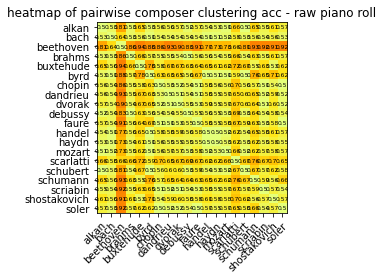

In [0]:

csv_comps = [alkan_csv, bach_csv, beethoven_csv,
               brahms_csv, buxtehude_csv, byrd_csv, 
               chopin_csv, dandrieu_csv, dvorak_csv, debussy_csv,
               faure_csv, handel_csv, haydn_csv,
               mozart_csv, scarlatti_csv, schubert_csv,
              schumann_csv, scriabin_csv, shostakovich_csv, soler_csv]

# all_pairs = [[a, b] for a in csv_comps for b in csv_comps if (a != b and a > b)]
# for p in list(all_pairs):
# 	print(p)
# 	run_clustering("kmeans", p)
# 	print("done!")
data = []
for a in csv_comps:
	tmp = []
	for b in csv_comps:
		tmp.append(run_representation_clustering([a, b], save=True) )
	data.append(tmp)
data = np.array(data)

# print(run_clustering_features("kmeans", [dandrieu_csv, soler_csv], save=True))
np.savetxt("ae_representation_accuracy.txt", data)
data = np.around(np.loadtxt("ae_representation_accuracy.txt"), decimals=2)

print(data)
# sys.exit()

fig, ax = plt.subplots()
im = ax.imshow(data, cmap="Wistia")

comps_names = [c[:-8] for c in csv_comps]

# We want to show all ticks...
ax.set_xticks(np.arange(len(comps_names)))
ax.set_yticks(np.arange(len(comps_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(comps_names)
ax.set_yticklabels(comps_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(comps_names)):
    for j in range(len(comps_names)):
        text = ax.text(j, i, data[i, j],
                        ha="center", va="center", color="black", size="6")

ax.set_title("heatmap of pairwise composer clustering acc - raw piano roll")
fig.tight_layout()
plt.show()



# plot latent representation

alkan_all.csv
bach_all.csv
beethoven_all.csv
brahms_all.csv
buxtehude_all.csv
byrd_all.csv
chopin_all.csv
dandrieu_all.csv
dvorak_all.csv
debussy_all.csv
faure_all.csv
handel_all.csv
haydn_all.csv
mozart_all.csv
scarlatti_all.csv
schubert_all.csv
schumann_all.csv
scriabin_all.csv
shostakovich_all.csv
soler_all.csv


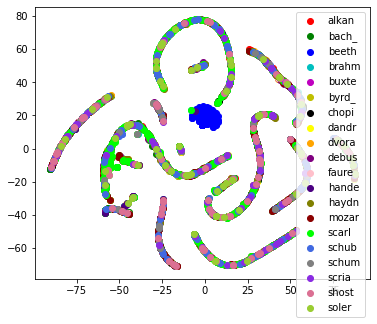

In [0]:
from sklearn.manifold import TSNE
def plot_repre(files):

	############################################################
	# Load the data
  X, y = get_csv_test_data(files)

  X = autoencoder_half.predict(X)

	############################################################
	# Fit and transform with a TSNE
  tsne = TSNE(n_components=2, random_state=0)

	############################################################
	# Project the data in 2D
  X_2d = tsne.fit_transform(X)

	############################################################
	# Visualize the data
  target_names = [f[:5] for f in files]
  target_ids = range(len(target_names))
  
  plt.figure(figsize=(6, 5))
  colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'yellow', 'orange', 'purple',
           'pink', 'indigo', 'olive', 'darkred', 'lime', 
           'royalblue', 'grey', 'blueviolet', 'palevioletred', 'yellowgreen']
  colors = colors[:len(target_names)]
  for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
  plt.legend()

  fig_dir = "drive/My Drive/10701/results/fig"
  name = "_".join(target_names)
  plt.savefig("{}/feature_ae_{}.png".format(fig_dir, name))
  plt.show()

plot_repre([alkan_csv, bach_csv, beethoven_csv,
                   brahms_csv, buxtehude_csv, byrd_csv, 
                   chopin_csv, dandrieu_csv, dvorak_csv, debussy_csv,
                   faure_csv, handel_csv, haydn_csv,
                   mozart_csv, scarlatti_csv, schubert_csv,
                  schumann_csv, scriabin_csv, shostakovich_csv, soler_csv])